In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [2]:
from dgym.envs.oracle import DockingOracle, NeuralOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'search_mode': 'fast',
    'scoring': 'gnina',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8.5, 9.5),
    acceptable=(6, 9.5)
)

Other objectives.

In [ ]:
import numpy as np
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.utility import ClassicUtilityFunction

# create evaluators
log_P_utility = ClassicUtilityFunction(
    RDKitOracle('MolLogP'),
    ideal=(1, 4),
    acceptable=(0, 5)
)

log_S_utility = ClassicUtilityFunction(
    DGLOracle('GCN_canonical_ESOL'),
    ideal=(-2, 0),
    acceptable=(-4, 0.5)
)

# create utility function
def composite_utility_function(molecules):
    return 0.2 * (log_P_utility(molecules) * log_S_utility(molecules)) + (0.8 * docking_utility(molecules))

Create selection loop.

In [187]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(np.nanmax(observations.annotations['ADAM17 affinity']))
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [ ]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
import numpy as np

# Get best molecules.
scores = docking_utility.oracle(deck)
best = np.argsort(scores)[-400:-300]
best_molecules = [d for d in deck[best] if len(d.reactants) == 2]

# Set up experiment.
designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = dg.collection.MoleculeCollection([best_molecules[-85]]).update_annotations(),
    assays = [log_P_utility.oracle, log_S_utility.oracle, docking_utility.oracle],
    budget = 1_000,
    utility_function = composite_utility_function,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10, 'strict': True}},
    {'name': 'ADAM17 affinity'},
    {'name': 'MolLogP'},
    {'name': 'GCN_canonical_ESOL'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = composite_utility_function,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 2
)

# Run experiment.
experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

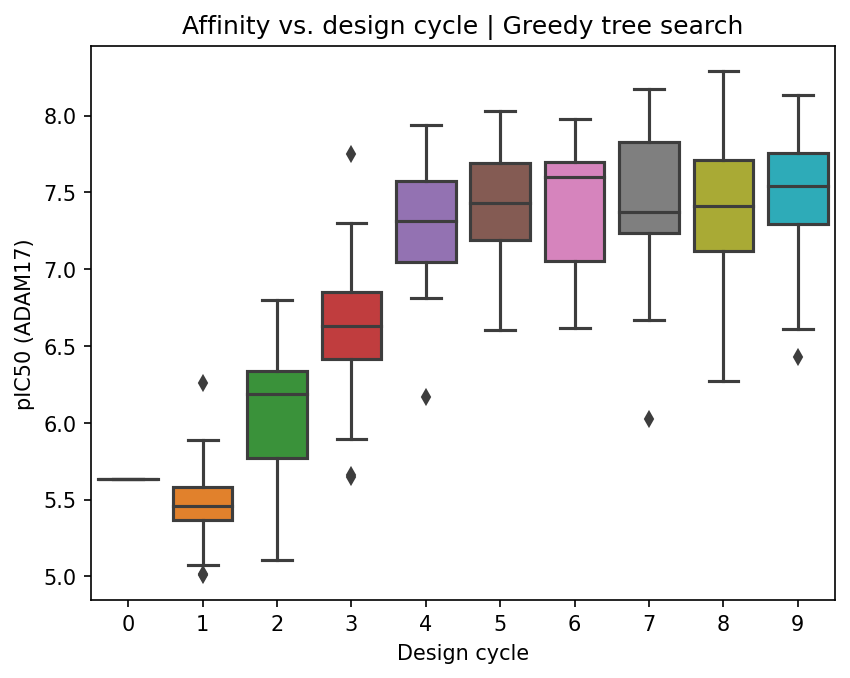

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

annotated_molecules = drug_env.library
g = sns.boxplot(
    x = [a.design_cycle for a in annotated_molecules],
    y = docking_utility.oracle(annotated_molecules),
)

g.set_title('Affinity vs. design cycle | Greedy tree search')
g.set_xlabel('Design cycle')
g.set_ylabel('pIC50 (ADAM17)')

plt.gcf().set_dpi(150)
plt.show()

In [173]:
docking_utility.ideal[-1] = 11

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/env

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/env

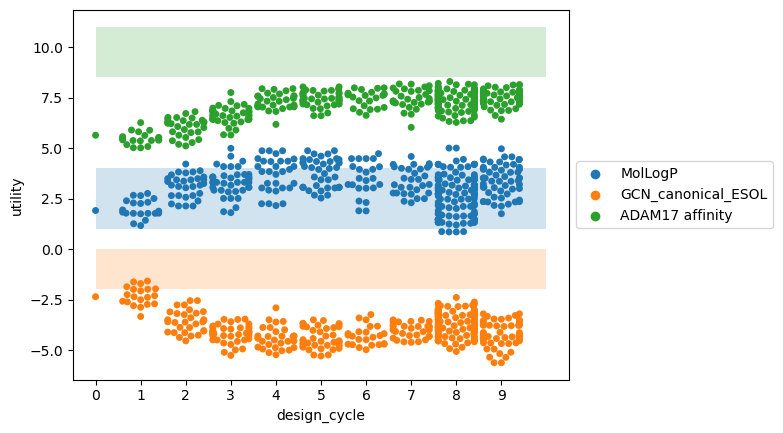

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

utility_fns = [log_P_utility, log_S_utility, docking_utility]

records = []
for utility_fn in utility_fns:
    scores = utility_fn.oracle(drug_env.library)
    for molecule, score in zip(drug_env.library, scores):
        records.append(
            {
                'design_cycle': molecule.design_cycle,
                'utility': score,
                'assay': utility_fn.oracle.name
            }
        )
        
g = sns.swarmplot(
    pd.DataFrame(records),
    x='design_cycle',
    y='utility',
    hue='assay',
)

plt.fill_betweenx(log_P_utility.ideal, 0, 10, alpha=0.2, zorder=-10)
plt.fill_betweenx(log_S_utility.ideal, 0, 10, alpha=0.2, zorder=-10)
plt.fill_betweenx(docking_utility.ideal, 0, 10, alpha=0.2, zorder=-10)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [110]:
library = drug_env.library

results = [
    library,
    log_P_utility.oracle(library),
    log_S_utility.oracle(library),
    docking_utility.oracle(library),
]

records = []
for mol, log_P, log_S, affinity in zip(*results):
    records.append(
        {
            'smiles': mol.smiles,
            'design cycle': mol.design_cycle,
            'log P': log_P,
            'log S': log_S,
            'ADAM17 pIC50': affinity
        }
    )

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


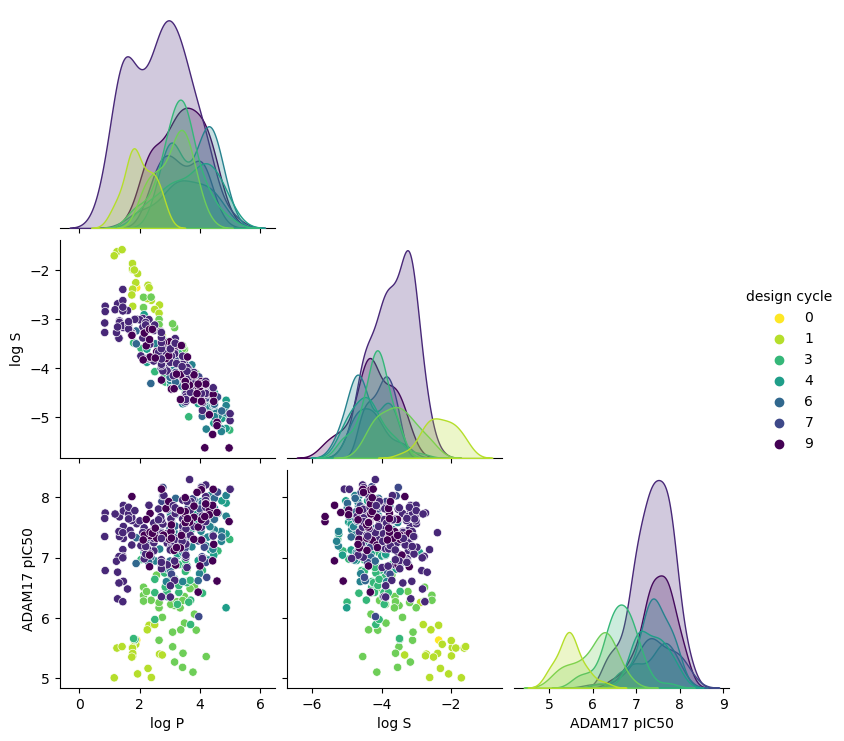

In [114]:
sns.pairplot(
    pd.DataFrame(records),
    vars=['log P', 'log S', 'ADAM17 pIC50'],
    hue='design cycle',
    corner=True,
    kind='scatter',
    palette='viridis_r'
)

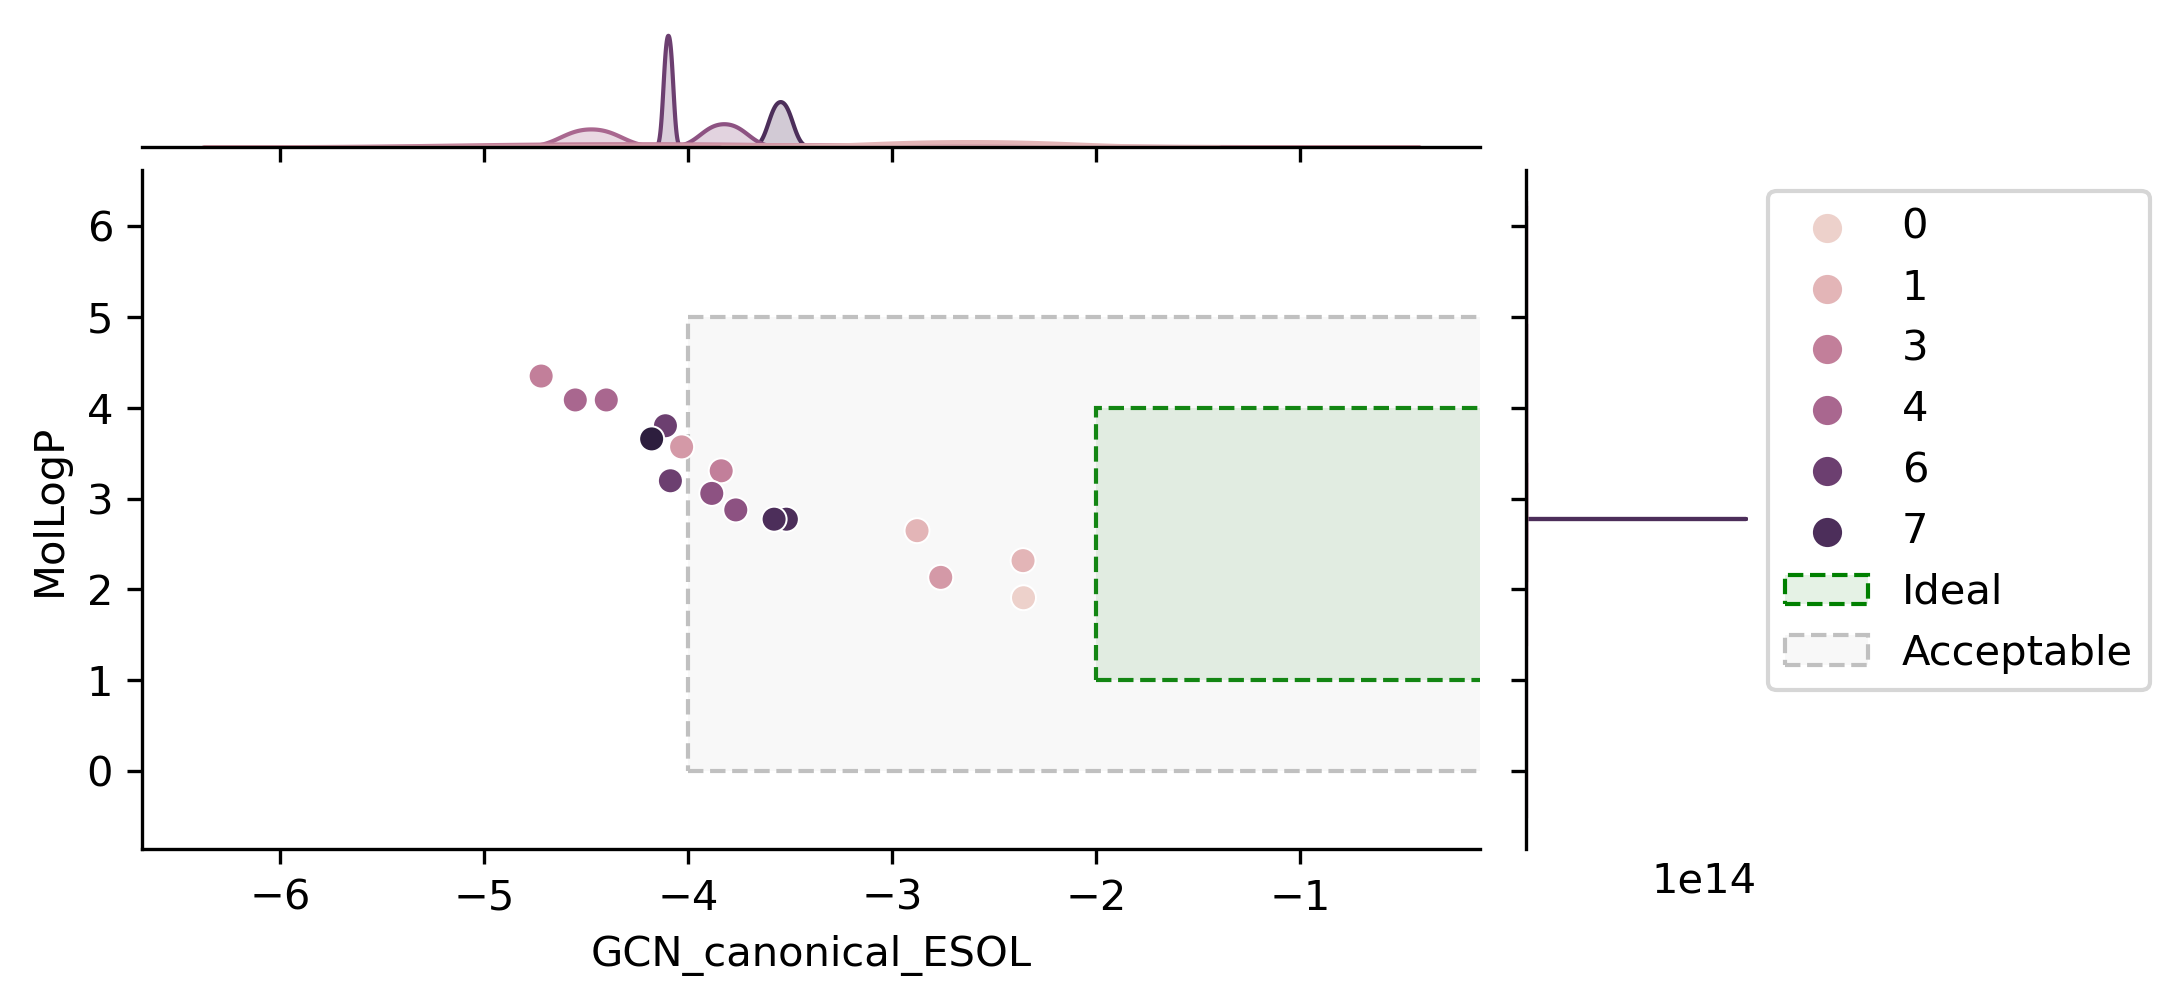

In [104]:
utility_fns = [log_S_utility, log_P_utility]

dg.plotting.plot(drug_env.library.annotated, utility_fns)